In [47]:
import matplotlib.pyplot as plt
import matplotlib as pmimg
import numpy as np
import skimage
from skimage import color
from skimage import data
from skimage import io
from tqdm import tqdm
import cv2

import os 
dir_path = os.getcwd()

In [48]:
def oneHot(imgTitle):
    animalLabel = imgTitle.split('.')[0][-3:]
    return animalLabel

In [49]:
def createTrainSet():
    trainingSet = []
#     data_dir = '/Users/Jack/Documents/ml/ml_book/DogOrCat/data/practice-train'
    data_dir = '/Users/Jack/Documents/ml/ml_book/DogOrCat/data/alternate_data/train'
    for imgLabel in tqdm(os.listdir(data_dir)[:5]):
        animalLabel = oneHot(imgLabel)
        #dog = [1, 0], cat = [0,1]
        oneHotLabel = []
        if animalLabel == 'dog':
            oneHotLabel = [1, 0]
        elif animalLabel == 'cat':
            oneHotLabel = [0, 1]
        else:
            print('nada')
            continue
        imgPath = os.path.join(data_dir, imgLabel)
        imgObj = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)
        imgObj = cv2.resize(imgObj, (50, 50))

        trainingSet.append([imgObj, oneHotLabel])
    return trainingSet

train = createTrainSet()

100%|██████████| 5/5 [00:00<00:00, 302.08it/s]


In [50]:
# Filter
# 
side_detector_layer = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
])

reverse_side_detector_layer = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
])

top_bottom_detector_layer = np.array([
    [1, 1, 1],
    [0, 0, 0],
    [-1, -1, 1]
])

angle_detector_layer = np.array([
    [0, 1, 1],
    [-1, 0, 1],
    [-1, -1, 0]
])


top_detector_layer = np.array([
    [1, 1, 1],
    [-1, -1, -1],
    [-1, -1, -1]
])


x_detector_layer = np.array([
    [1, 0, 1],
    [0, 1, 0],
    [1, 0, 1]
])

right_knight_detector_layer = np.array([
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [0, 0, 0, 1, 1],
    [0, 0, 0, 1, 1],
    [0, 0, 0, 1, 1]
]);

left_knight_detector_layer = np.array([
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 0, 0, 0],
    [1, 1, 0, 0, 0],
    [1, 1, 0, 0, 0]
]);

small_angle_detector_layer = np.array([
    [1, 1, 0],
    [1, 0, 1],
    [0, 1, 1],
])

horiz_filter = np.array([
    [1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1],
])
vertical_filter = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
])
whole_filter = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
])

In [51]:
def relu(imgMatrix):
    filterMask = imgMatrix > 0
    reluMatrix = imgMatrix * filterMask
    return reluMatrix

In [56]:
def convolve_2d(img, filter, padding='same', stride=1, depth=1):
    if padding == 'same':
        padding = int(len(filter)/2)
        
    outputDim = len(img[0]) - len(filter[0]) + (2*padding) * stride + 1
    padded_img = np.pad(img, ((padding, padding)), 'constant', constant_values=(0, 0))
    resultArr = np.zeros((depth, outputDim, outputDim), dtype=int)
    
    filterLength = len(filter)

    for zIdx in range(depth):
        for yIdx in range(padded_img.shape[0] - (2 * padding)):
            for xIdx in range(padded_img.shape[1] - (2 * padding)):
                yEnd = yIdx + len(filter)
                xEnd = xIdx + len(filter)
                windowRows = padded_img[yIdx:yEnd]
                window = np.zeros((len(filter), len(filter)))
                xWin = 0
                for row in windowRows:
                    window[xWin] = row[xIdx:xEnd]
                    xWin += 1
                    
                filteredWindow = window * filter
                nodeValue = np.average(filteredWindow)
                resultArr[zIdx][yIdx][xIdx] = nodeValue
    #Boom!
    return resultArr

    
def createConvolutionalLayer(filtersArr, img):
    convFilterArr = np.zeros((len(filtersArr), img.shape[0], img.shape[1]))
    idx = 0
    for filter in filtersArr:
        convResult = convolve_2d(img, filter, depth=1)
        convFilterArr[idx] = convResult
        idx += 1
    return convFilterArr    

def train_conv_layer(imgSet, filters):
    imgSet = np.array(imgSet)
    x = 0
    print('CONVOLUTIONALLLLLL')
    for img in tqdm(imgSet):
        imgSet[x][0] = createConvolutionalLayer(filters, img[0])
        x += 1
    return imgSet

filters = [
    side_detector_layer,
    reverse_side_detector_layer,
    small_angle_detector_layer,
    top_bottom_detector_layer,
    angle_detector_layer,
    top_detector_layer,
    left_knight_detector_layer,
    right_knight_detector_layer,
    x_detector_layer
]


def relu_layer(imgArr):
    imgObjIdx = 0
    print('RELUUUUUU')
    for imgObj in tqdm(imgArr):
        filterIdx = 0
        listOfFilteredImages = imgObj[0]
        for imgMatrix in listOfFilteredImages:
            reluImg = relu(imgMatrix)
            imgObj[0][filterIdx] = reluImg
            filterIdx += 1
        
        imgArr[imgObjIdx] = imgObj
        imgObjIdx += 1  
    return imgArr

def max_pool(img, filter, padding='same', stride=1, depth=1):
    if padding == 'same':
        padding = int(len(filter)/2)
        
    outputDim = len(img[0]) - len(filter[0]) + (2*padding) * stride + 1
    padded_img = np.pad(img, ((padding, padding)), 'constant', constant_values=(0, 0))
    resultArr = np.zeros((depth, outputDim, outputDim), dtype=int)
    
    filterLength = len(filter)

    for zIdx in range(depth):
        for yIdx in range(padded_img.shape[0] - (2 * padding)):
            for xIdx in range(padded_img.shape[1] - (2 * padding)):
                yEnd = yIdx + len(filter)
                xEnd = xIdx + len(filter)
                windowRows = padded_img[yIdx:yEnd]
                window = np.zeros((len(filter), len(filter)))
                xWin = 0
                for row in windowRows:
                    window[xWin] = row[xIdx:xEnd]
                    xWin += 1
                    
                filteredWindow = window * filter
                nodeValue = np.amax(filteredWindow)
                resultArr[zIdx][yIdx][xIdx] = nodeValue
    #Boom!
    return resultArr

def max_pool_layer(imgArr, filters):
    print(imgArr.shape)
    imgObjIdx = 0
    for img in tqdm(imgArr):
        filterIdx = 0
        
        for imgMat in imgArr[imgObjIdx][0]:
            maxedMat = max_pool(imgMat, filters[filterIdx])
            imgArr[imgObjIdx][0][filterIdx] = maxedMat
            filterIdx += 1
            
        imgObjIdx += 1
        
    return imgArr


In [57]:
# Begin training
trainSet = train
trainSet = train_conv_layer(trainSet, filters)
trainSet = relu_layer(trainSet)
trainSet = max_pool_layer(trainSet, filters)

  0%|          | 0/5 [00:00<?, ?it/s]

CONVOLUTIONALLLLLL


  0%|          | 0/5 [00:00<?, ?it/s]

RELUUUUUU
(5, 2)
[[[12  6  2 ... 28  0  0]
  [12  6  2 ... 28  0  0]
  [13  6  2 ... 28  0  0]
  ...
  [ 5 19 13 ...  3  0  0]
  [ 5 19 13 ...  3  0  0]
  [ 2 12 13 ...  3  0  0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[ 27  38  39 ...  96  96  76]
  [ 28  38  41 ... 103 103  96]
  [ 29  40  41 ... 103 103 103]
  ...
  [ 22  32  49 ...  35  36  36]
  [ 22  30  41 ...  35  35  35]
  [ 14  22  30 ...  32  35  35]]]
[[[12 12 13 ... 36  1  0]
  [ 7  9 14 ... 41  0  0]
  [12 13 15 ... 39 36 36]
  ...
  [ 8 16 17 ... 13 13 11]
  [10 23 24 ... 16 12 12]
  [ 8 16 17 ... 13 13 13]]]


 20%|██        | 1/5 [00:00<00:01,  2.80it/s]

[[[ 0  0  0 ...  0  0  0]
  [ 7  5  0 ... 16  0  0]
  [ 9  7  5 ... 16 16  0]
  ...
  [ 5 15 12 ...  0  0  0]
  [ 7 15 15 ...  3  0  0]
  [ 7 16 22 ... 13  3  0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[ 0  9 16 ... 51 67 69]
  [ 7 12 17 ... 56 71 73]
  [18 25 27 ... 58 73 77]
  ...
  [23 27 38 ... 30 30 30]
  [26 30 39 ... 29 29 29]
  [26 31 39 ... 28 28 28]]]
[[[34 38 41 ... 62 34  0]
  [34 38 41 ... 66 41 41]
  [35 38 41 ... 68 62 62]
  ...
  [36 42 48 ... 33 33 33]
  [36 42 48 ... 32 32 32]
  [36 42 48 ... 32 32 32]]]
[[[20 30 37 ... 79 69 79]
  [22 33 33 ... 85 79 85]
  [24 33 37 ... 85 85 85]
  ...
  [19 26 35 ... 30 29 30]
  [19 32 34 ... 29 30 29]
  [19 26 33 ... 30 25 30]]]
[[[ 8  2  0 ...  0  0  0]
  [ 8  3  2 ...  0  0  0]
  [ 8  6  2 ...  0  0  0]
  ...
  [10  7  5 ...  8  0  0]
  [ 8  7  5 ...  8  0  0]
  [ 7  7  5 ...  0  0  0]]]
[[[ 0  0  0 ...  2  7  8]
  [ 0  0  0 ...  2  7 11]


 40%|████      | 2/5 [00:00<00:01,  2.77it/s]

[[[72 72 73 ... 55 29  0]
  [72 72 73 ... 55 30 27]
  [72 72 73 ... 62 59 54]
  ...
  [66 66 66 ... 87 87 87]
  [63 65 65 ... 82 82 82]
  [58 62 64 ... 73 73 73]]]
[[[58 61 62 ... 75 77 65]
  [58 58 66 ... 81 70 69]
  [58 61 62 ... 78 77 70]
  ...
  [47 50 57 ... 69 68 69]
  [40 44 52 ... 64 56 64]
  [33 41 44 ... 53 47 53]]]
[[[37 12  1 ...  0  0  0]
  [37 20  5 ...  0  0  0]
  [37 30  5 ...  0  0  0]
  ...
  [ 0  0  4 ...  0  0  0]
  [ 0  0  4 ...  0  0  0]
  [ 0  0  4 ...  0  0  0]]]
[[[ 0  0  0 ...  0  0  5]
  [ 0  0  0 ...  0  0  6]
  [ 0  0  0 ...  2  1 11]
  ...
  [ 0  0 12 ...  3  4  6]
  [ 0  0  9 ...  3  4  6]
  [ 0  0  5 ...  2  4  6]]]
[[[ 87 118 124 ...  84  84  55]
  [ 87 118 127 ...  87  87  84]
  [ 84 112 127 ...  90  84  87]
  ...
  [ 65  69  69 ...  64  62  57]
  [ 57  65  65 ...  60  56  52]
  [ 34  57  57 ...  58  55  49]]]
[[[45 44 40 ... 24  0  0]
  [47 51 44 ... 26  0  0]
  [45 46 45 ... 24 24 24]
  ...
  [27 23 23 ... 22 20 20]
  [27 27 27 ... 22 21 18]
  [27 27

 60%|██████    | 3/5 [00:01<00:00,  2.77it/s]

[[[ 0  0  0 ...  0  0  0]
  [29  9  0 ...  0  0  0]
  [36 29  9 ...  3  0  0]
  ...
  [24  0  2 ...  0  0  0]
  [28  5  6 ...  0  0  0]
  [26 17 20 ... 11  0  0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[ 0 33 57 ... 84 83 81]
  [26 39 58 ... 88 88 85]
  [54 71 77 ... 94 92 89]
  ...
  [59 59 59 ... 71 67 64]
  [58 58 58 ... 68 64 61]
  [57 57 57 ... 66 62 59]]]
[[[109 117 117 ...  50  30   0]
  [109 117 118 ...  50  31  29]
  [109 117 118 ...  55  55  53]
  ...
  [ 57  57  56 ...  67  64  61]
  [ 57  57  57 ...  64  60  56]
  [ 57  57  57 ...  63  58  54]]]
[[[ 75  93 102 ...  69  68  69]
  [ 69  91 104 ...  75  71  72]
  [ 75  93 106 ...  79  75  69]
  ...
  [ 55  54  55 ...  53  51  50]
  [ 54  47  54 ...  49  48  42]
  [ 43  44  43 ...  50  46  43]]]
[[[ 0  0 19 ...  2  0  0]
  [ 0  0 38 ...  2  0  0]
  [ 1  0 59 ...  2  0  0]
  ...
  [ 0  3  2 ... 11  0  0]
  [ 0  3  1 ... 10  0  0]
  [ 0  2

 80%|████████  | 4/5 [00:01<00:00,  2.64it/s]

[[[ 0  6 11 ... 51 51 51]
  [ 6  6 12 ... 53 53 52]
  [12 12 13 ... 54 54 53]
  ...
  [54 54 55 ... 32 25 21]
  [49 49 50 ... 31 23 19]
  [46 46 47 ... 26 21 18]]]
[[[ 39  61  61 ...  35  18   0]
  [ 49  78  83 ...  35  19  19]
  [ 58  94 105 ...  36  34  34]
  ...
  [ 55  55  55 ...  24  24  24]
  [ 50  50  50 ...  25  23  23]
  [ 46  46  46 ...  25  22  22]]]
[[[15 14 35 ... 43 43 43]
  [16 16 35 ... 45 44 45]
  [17 17 57 ... 45 46 45]
  ...
  [40 41 42 ... 17 15 17]
  [35 36 36 ... 15 17 15]
  [33 33 33 ... 17 15 17]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[[[170 170 170 ... 170 170 113]
  [170 170 170 ... 170 170 170]
  [170 170 170 ... 170 170 170]
  ...
  [170 170 170 ... 170 170 170]
  [170 170 170 ... 170 170 170]
  [113 170 170 ... 170 170 170]]]
[[[56 56 56 ... 

100%|██████████| 5/5 [00:01<00:00,  2.65it/s]

[[[141 141 141 ... 141 141 141]
  [141 141 141 ... 141 141 141]
  [141 141 141 ... 141 141 141]
  ...
  [141 141 141 ... 141 141 141]
  [141 141 141 ... 141 141 141]
  [141 141 141 ... 141 141 141]]]


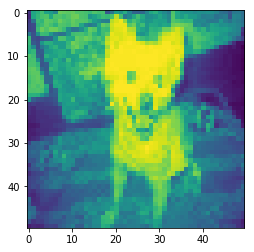

In [61]:
# Real image
animalIdx = 2
plt.imshow(train[animalIdx][0])

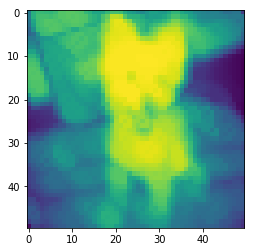

In [62]:
filterToShow = 2
plt.imshow(trainSet[animalIdx][0][2])